# ARIMA for Time Series Analysis

**ARIMA (Autoregressive Integrated Moving Average)** is a statistical analysis model that is used to forecast time series data. It's particularly `useful in understanding and predicting time series data showing some form of linear trend or seasonal patterns`. 

ARIMA models are characterized by three parameters: (`p`, `d`, `q`) each of which technique contributes to the final forecast as part of the class of linear model of ARIMA.

- `Autoregressive (AR)  p`: This part leverages the idea that past stock prices can influence future prices. This is based on the premise that stock market performance is somewhat consistent over time, although not perfectly predictable. **In an autoregression model, we forecast the variable of interest using a linear combination of past values of that variable**. The term autoregression indicates that it is a regression of the variable against itself. That is, we use lagged values of the target variable as our input variables to forecast values for the future. An autoregression model of order p will look like: $Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + ... + \phi_p Y_{t-p} + \epsilon_t$ In the  equation, the currently observed value of Y is a linear function of its past p values. [ 0, p] are the regression coefficients that are determined after training. There are some standard methods to determine optimal values of p one of which is, analyzing Autocorrelation and Partial Autocorrelation function plots.  (those plot help determine past value dependency which in turn helps us deduce p in AR.)
    - The `autocorrelation function (ACF)` is the correlation between the current and the past values of the same variable. It also considers the translative effect that values carry over with time apart from a direct effect. For example, prices of oil 2 days ago will affect prices 1 day ago and eventually, today. But the prices of oil 2 days ago might also have an effect on today which ACF measures.

    - `Partial Autocorrelation (PACF)` on the other hand measures only the direct correlation between past values and current values. For example, PACF will only measure the effect of prices of oil 2 days ago on today with no translative effect.
           

- `Integrated (I)  d`: **This represents differencing the observations to make the time series stationary**. A stationary time series has properties that do not depend on the time at which the series is observed. Differencing helps in removing trends or seasonal structures in the stock prices, making the time series more predictable. A differencing factor, d=1 means a lag of i.e.Yt-Yt-1. 


- `Moving Average (MA)  q`: **This part accounts for the possibility that past prediction errors can influence future stock prices**. It helps to smooth out short-term fluctuations and highlight longer-term trends or cycles. Equation: $Y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_q \epsilon_{t-q}$ Where $\mu$ is the mean of the series, and $\theta$ are the parameters of the model while $\epsilon_t$, is called an error and it represents the random residual deviations between the model and the target variable. Since $\epsilon_t$ can only be determined after fitting the model and since it’s a parameter too so in this case $\epsilon_t$ is an unobservable parameter.

## An Application with AMZN stock

In [148]:
import pandas as pd
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [137]:
data = pd.read_excel('final_dataset.xlsx')
amzn_data = data[data['Ticker'] == 'AMZN']

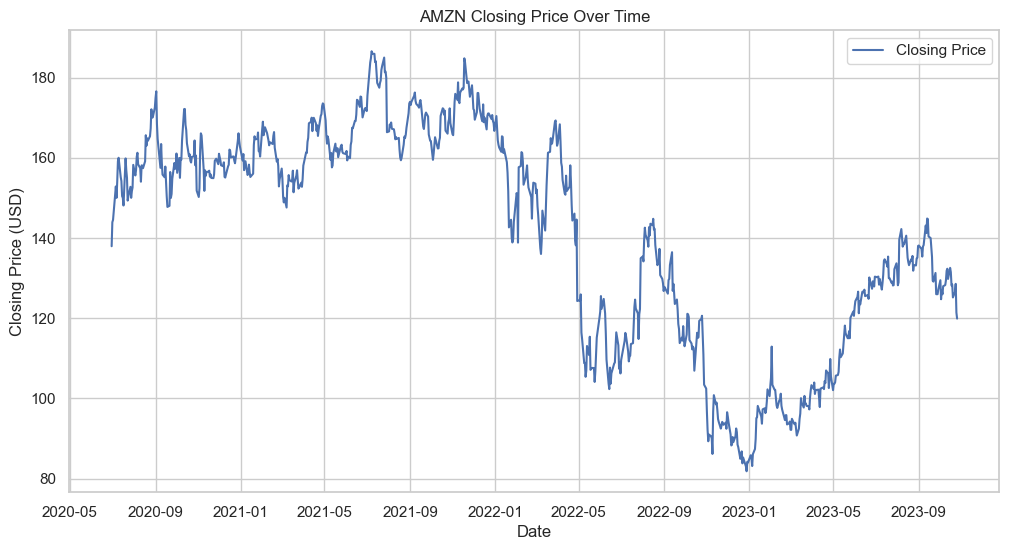

In [138]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.plot(amzn_data['Date'], amzn_data['Close'], label='Closing Price')
plt.title('AMZN Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In analyzing the historical closing prices of a stock, it is often important to ensure that the data used to train a predictive model like an ARIMA model is representative of the underlying process we are trying to model. After examination of the stock's closing price data, I chose to truncate the dataset at January 2022 because the behavior of the stock after 2022 may have been influenced by exceptional `market conditions that are not expected to be indicative of future trends`. For example, the economic impact of the COVID-19 pandemic caused unprecedented volatility in stock prices, which could introduce noise and bias into our model. By focusing on the post-2022 period, I aim to capture more normal market conditions that are more likely to persist into the future.


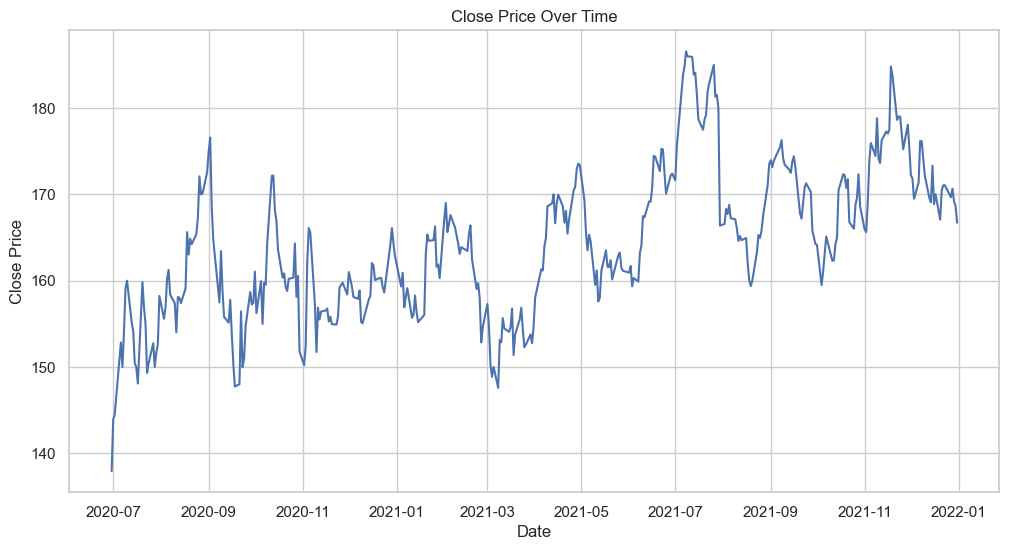

In [139]:
filtered_data = data[(data['Ticker'] == 'AMZN') & (data['Date'] < '2022-01-01')]
sns.set(style="whitegrid")
time_series_data = filtered_data[['Date', 'Close']].copy()
time_series_data.set_index('Date', inplace=True)

plt.figure(figsize=(12, 6))
plt.title('Close Price Over Time')
plt.plot(time_series_data['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

### STL Decomposition

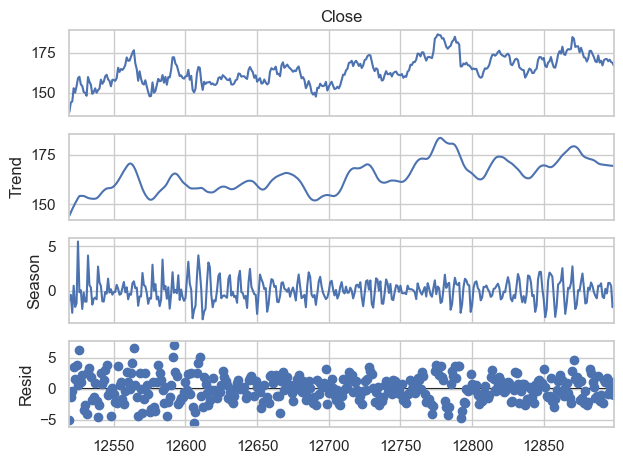

In [140]:
# Perform STL decomposition
stl = sm.tsa.STL(filtered_data['Close'], period=7)
result = stl.fit()

# Plot the decomposed components
result.plot()
plt.show()


- **Trend Analysis**: No strong long-term trend is observed, meaning that the time series does not show a consistent direction of growth or decline over the period captured in the data.
- **Seasonality Analysis**: Clear weekly patterns are present, indicating that the time series is influenced by factors that repeat on a weekly basis.
- **Residual Analysis**: The residuals do not show any particular structure, indicating that the model has captured the main characteristics of the time series data. There are no obvious outliers or patterns in the residuals, which is an indication of a good fit for the components chosen.

### Check for Stationarity

Results of Dickey-Fuller Test:
Test Statistic                  -4.155813
p-value                          0.000782
#Lags Used                       0.000000
Number of Observations Used    380.000000
Critical Value (1%)             -3.447676
Critical Value (5%)             -2.869176
Critical Value (10%)            -2.570838
dtype: float64


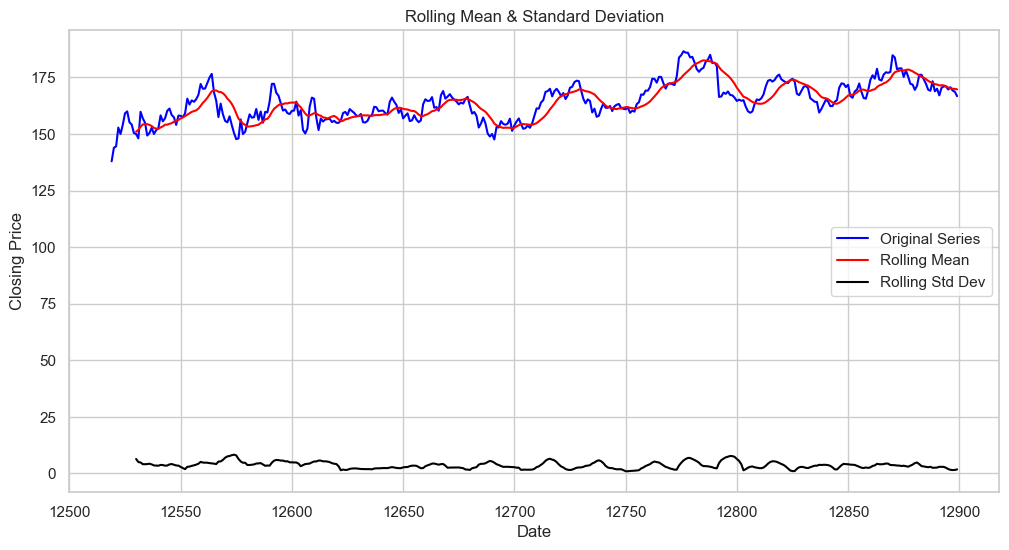

In [141]:
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Apply ADF test on the series
adf_test(time_series_data['Close'])
# Calculate the rolling mean and rolling standard deviation
rolling_mean = filtered_data['Close'].rolling(window=12).mean()
rolling_std = filtered_data['Close'].rolling(window=12).std()
plt.figure(figsize=(12,6))
plt.plot(filtered_data['Close'], color='blue', label='Original Series')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std Dev')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


1. **Test Statistic**: The more negative this statistic, the more likely we are to reject the null hypothesis (which states that the series is non-stationary). 
2. **p-value**: A p-value below a threshold (commonly 0.05) suggests that the series is stationary. 
3. **Critical Values**: These values correspond to different levels of confidence. If the test statistic is less (more negative) than the critical value, the null hypothesis can be rejected. The test statistic of -4.155813 is lower than all the critical value thresholds (1%, 5%, 10%).
4. **Original Series**: This represents the actual closing prices over time. It shows fluctuations, which is typical for financial time series data.
5. **Rolling Mean**: The rolling mean appears to be relatively constant over time, with no clear trend upwards or downwards. This suggests that the mean of the series does not change much over time, which is a characteristic of a stationary time series.
5. **Rolling Standard Deviation**: The rolling standard deviation is quite flat and low, indicating that the volatility of the closing price is relatively constant over the time period shown. This also supports the stationarity of the time series because the spread of the closing prices (volatility) isn't varying over time.

Both the rolling mean and rolling standard deviation lines being relatively flat and not showing distinct patterns over time (like a consistent upward or downward trend) is a visual indicator that the series could be stationary. This visual interpretation aligns with the results of the Augmented Dickey-Fuller test you provided earlier, which had a low p-value, **allowing us to reject the null hypothesis and conclude that the series is stationary**.

The flatness of the rolling standard deviation, in particular, is a good sign, as it suggests that the series' volatility is not dependent on time, which is another indicator of stationarity.

### ACF and PACF plots

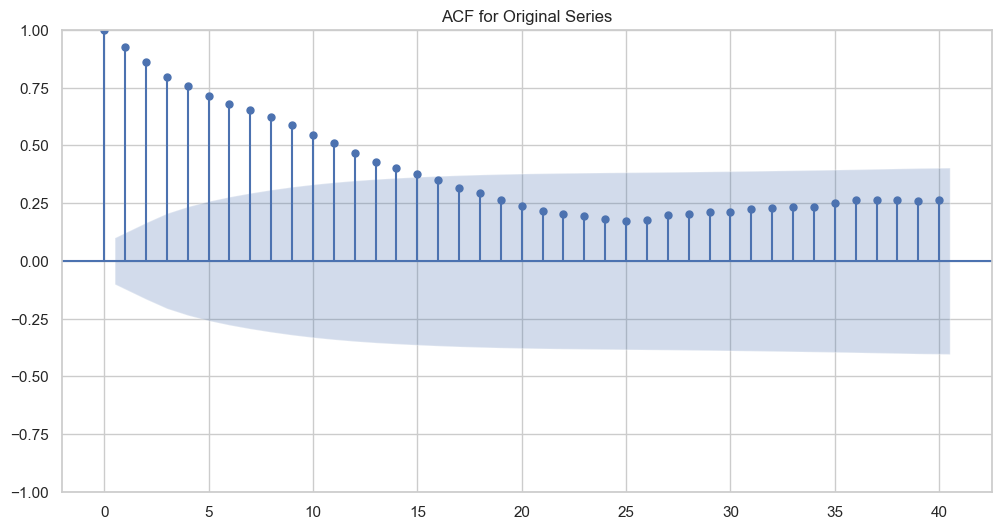

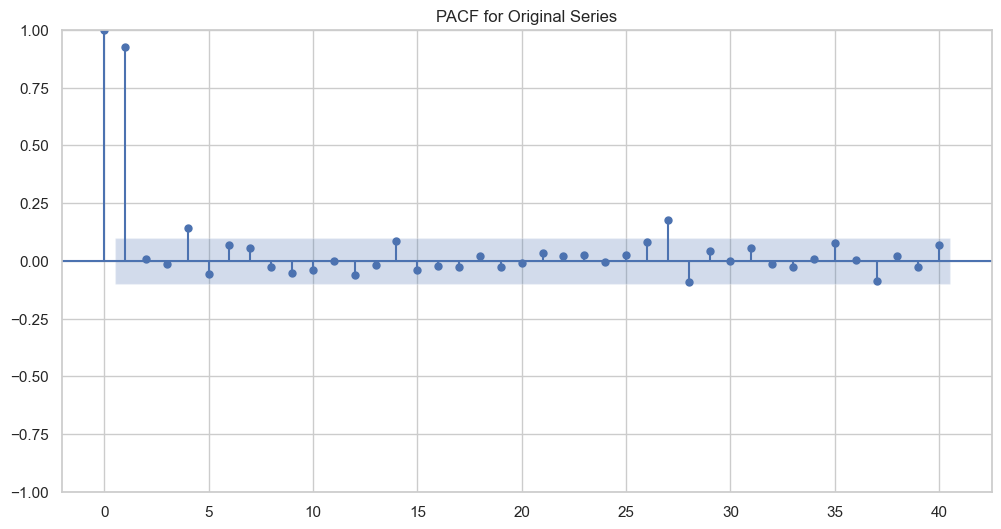

In [142]:
plt.figure(figsize=(12, 6))
plot_acf(time_series_data['Close'], ax=plt.gca(), lags=40)
plt.title('ACF for Original Series')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(time_series_data['Close'], ax=plt.gca(), lags=40)
plt.title('PACF for Original Series')
plt.show()


**`ACF` for Original Series**:
- The `ACF` plot shows the correlation of the time series with its own lags, up to 40 lags (based on the x-axis).
- The slow decay of the autocorrelation values as the lag increases suggests that there's a long-term positive autocorrelation.
- Since the `ACF` tailing off slowly and the series has been found to be stationary, it indicates that the series might be better explained by an ARIMA model rather than a simple `AR` or `MA` model.

**`PACF` for Original Series**:

- The `PACF` plot shows the partial correlation of the series with its own lags, controlling for the values of the intermediate lags.
- The sharp cut-off after the first lag in the `PACF` plot indicates that a lag-1 term is significant in the series.
- The `PACF` being significant at the first lag and then cutting off suggests an AR(1) component might be a good starting point for the AR part of an ARIMA model.



### Train & Test Split

In [143]:
# Suppose we keep the last 20% of observations for testing
split_ratio = 0.8
split_idx = int(len(filtered_data) * split_ratio)

train_data = filtered_data['Close'][:split_idx]
test_data = filtered_data['Close'][split_idx:]
print(len(train_data),len(test_data))

304 77


### Fitting ARIMA

The ACF showing a slow decay could mean that there is an autoregressive component in the data.
The PACF cutting off after lag 1 suggests that an AR(1) term is likely important in the data.
Combining this information with the stationarity results, we start with an ARIMA model with 1 autoregressive term (p=1), potentially no differencing (d=0 since the data is stationary), and then determine the moving average part (q) based on the significance of the lags in the ACF plot

In [144]:
# Fit the ARIMA model (assuming the order (1,0,0) based on the PACF and ACF analysis)
model = ARIMA(train_data, order=(1,0,0))
fitted_model = model.fit()

print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  304
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -766.529
Date:                Sat, 27 Jan 2024   AIC                           1539.058
Time:                        21:49:26   BIC                           1550.209
Sample:                             0   HQIC                          1543.519
                                - 304                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        161.8103      2.812     57.543      0.000     156.299     167.322
ar.L1          0.9460      0.016     59.180      0.000       0.915       0.977
sigma2         9.0039      0.567     15.878      0.0

### Model Diagnostics

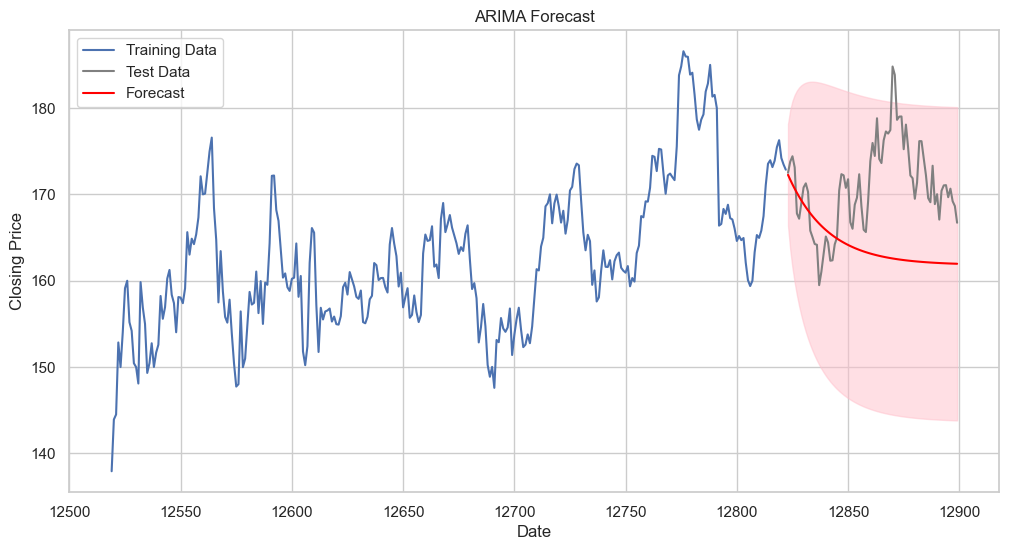

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  304
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -766.529
Date:                Sat, 27 Jan 2024   AIC                           1539.058
Time:                        21:49:26   BIC                           1550.209
Sample:                             0   HQIC                          1543.519
                                - 304                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        161.8103      2.812     57.543      0.000     156.299     167.322
ar.L1          0.9460      0.016     59.180      0.000       0.915       0.977
sigma2         9.0039      0.567     15.878      0.0

In [145]:
# Forecast the next steps ahead in the future
forecast_steps = len(test_data)
forecast = fitted_model.get_forecast(steps=forecast_steps)
forecast_index = test_data.index
forecast_mean = forecast.predicted_mean

# Confidence intervals for the forecasts
confidence_intervals = forecast.conf_int()

# Plot the training data, test data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data', color='gray')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='red')

# Plot the confidence intervals
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.5)
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

print(fitted_model.summary())


#### Summary Output Interpretation
- Model Information: The model used is an ARIMA(1, 0, 0), which means it has one autoregressive term and no differencing or moving average components. This aligns with the earlier analysis based on the ACF and PACF plots.
- Coefficients:
    - const: The coefficient for the constant term is significant, with a very low p-value (close to 0), suggesting that the model includes a constant term in the prediction.
    - ar.L1: The coefficient for the first lag is also significant with a p-value close to 0, confirming that the past value is useful in predicting the future value in the series.
    - sigma2: Represents the variance of the residuals. The lower this value, the better the model fits your data.

#### Diagnostic Tests:
- Ljung-Box Test: A p-value of 0.88 suggests that there is no significant autocorrelation in the residuals at lag 1, which is good.
- Jarque-Bera Test: A p-value of 0.00 indicates that the residuals are not normally distributed, which could be a concern.
- Heteroskedasticity Test: The p-value of 0.00 suggests the presence of heteroskedasticity, which means the variance of the residuals is not constant over time.
- Skew and Kurtosis: The skewness is close to 0, suggesting the residuals are symmetrically distributed. Kurtosis of 4.76 suggests a leptokurtic distribution, which means the residuals have heavy tails or outliers.

#### Forecast Plot Interpretation:
- Training Data (Blue Line): The historical data used to train the model.
- Test Data (Gray Line): The out-of-sample actual closing prices not used for training.
- Forecast (Red Line with Confidence Interval): The predicted values with their confidence interval. The forecast seems to follow the trend of the test data initially but then diverges.
- Confidence Interval (Red Shaded Area): Represents the uncertainty in the forecast. The wider this area, the less certain the model is about the forecast.

In [150]:
actuals = test_data  # the actual test set values
predictions = forecast_mean  # the predicted values from ARIMA

# Calculate errors
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse_val = rmse(actuals, predictions)

# Print out the errors
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse_val}')


MAE: 7.632940590731813
MSE: 84.90333375839516
RMSE: 9.214300502935378


Range of Data for feature Close:
- Max: 381
- 75th Percentile: 186.57
- Mean: 170.07
- Median (50th Percentile): 164.20
- 25th Percentile: 158.07
- Min: 137.94
- Standard Deviation: 8.53


Mean Absolute Error (MAE): 7.63
The MAE is less than the standard deviation of the dataset, which is a good sign. It indicates that, on average, the forecast errors are smaller than the typical variation in the data.

Mean Squared Error (MSE): 84.90
The MSE is quite a bit higher than the MAE due to the squaring of the errors, which emphasizes larger errors. It's about 116.2% of the variance (as standard deviation squared is 72.80), suggesting that the errors might have a few outliers or some larger errors, because it is higher than the variance of the data.

Root Mean Squared Error (RMSE): 9.21
The RMSE is slightly higher than the standard deviation of your dataset. This suggests that the errors are, on average, slightly larger than the typical variation in your data, but still within a comparable range.
Interpretation:
Given that the mean of  data is around 170, an MAE of 7.63 represents an average error of about 4.49% relative to the mean. Similarly, an RMSE of 9.21 is about 5.42% of the mean. These percentages are relatively small, indicating a model that performs reasonably well.
However, the context of what these errors mean practically is important. Since the time series represents something like stock prices, and i am  making trading decisions, even a 5% error could be significant. 

Summary Statistics:
 count    304.000000
mean       0.074269
std        3.272734
min      -23.869279
25%       -1.536436
50%        0.241036
75%        1.887475
max       11.002567
dtype: float64


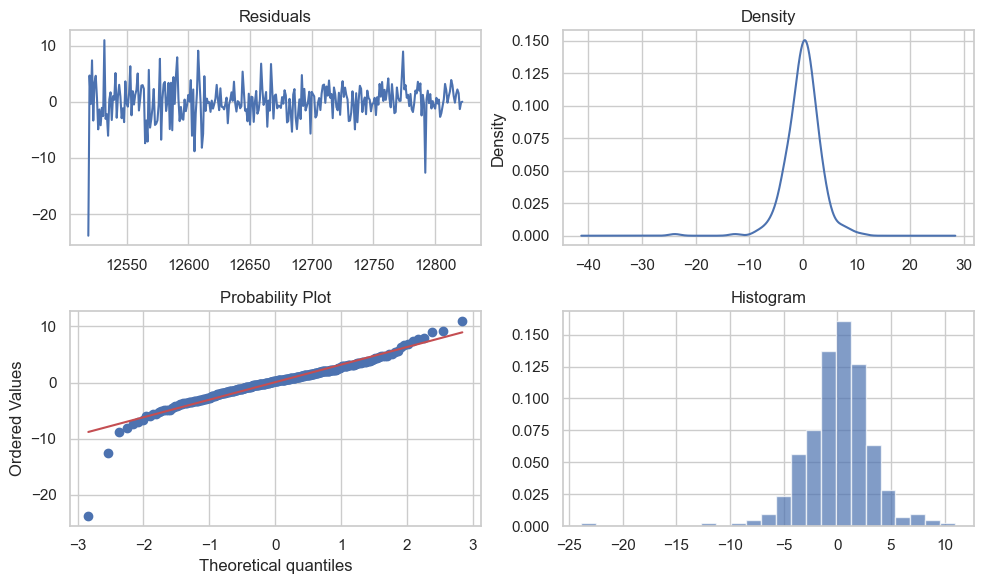

In [146]:
def analyze_residuals(residuals):
    print('Summary Statistics:\n', residuals.describe())
    
    plt.figure(figsize=(10,6))
    plt.subplot(221)
    residuals.plot(title='Residuals')
    
    plt.subplot(222)
    residuals.plot(kind='kde', title='Density')
    
    plt.subplot(223)
    stats.probplot(residuals, dist="norm", plot=plt)
    
    plt.subplot(224)
    plt.hist(residuals, bins=25, alpha=0.7, density=True)
    plt.title('Histogram')

    plt.tight_layout()
    plt.show()

# Now call the function with the residuals of your model
analyze_residuals(fitted_model.resid)



The residuals seem to be randomly distributed around zero without clear patterns, which is good.
The histogram and density plot suggest that the residuals may not be normally distributed due to heavy tails, which could be a concern. This might indicate that extreme values are more frequent than expected for a normal distribution.
The Q-Q plot further supports the presence of heavy tails or outliers, which the ARIMA model did not fully capture. This could affect the accuracy of the model, especially in predicting extreme events.


### Final Analysis and Possible Recommendations
The model has done a fair job of capturing the pattern in the historical data and can forecast the direction of the time series to some extent. However, there are a few concerns:

The residuals do not follow a normal distribution and there is evidence of heteroskedasticity, which can affect the confidence intervals and forecasts.
The forecast confidence interval widens as we move further out, indicating increasing uncertainty in the forecasted values.

- To deal with heteroskedasticity, GARCH models or ARIMA with conditional heteroskedasticity (such as ARIMA-GARCH) could be considered.
- Model diagnostics should be conducted, including residual analysis to ensure that the model's assumptions are not violated.
- Cross-validation or out-of-time validation could help in assessing the model's predictive power more reliably.